Parameters

In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import numpy as np
import torch
import torch.optim
from torch import nn
import torch.nn.functional as F
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
#from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import skimage
import time
from Model.Downsampler import *
from util import *
# noise
sigma = 25
sigma_ = sigma/255.
imsize = -1 
# SR
factor = 4 # 8
# Inpainting
zero_f=0.9 #Percentage of obscured pixels

Set path 

In [3]:
#for task include SR   
SR=True
img_path= 'Data/SR/img_002_SRF_4_HR.png'

LR_image = 'Data/SR/img_002_SRF_4_LR_LANCZOS.png'#bicubic
HR_image = img_path

#for denoise + mask task the three path is the same
# SR=False
# img_path= 'Data/Denoising/image_Peppers512rgb.png'

# LR_image = img_path
# HR_image = img_path

Get images

HR and LR resolutions: (288, 288), (72, 72)


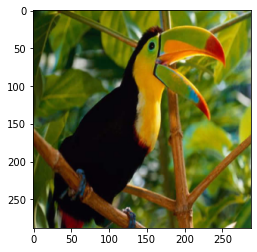

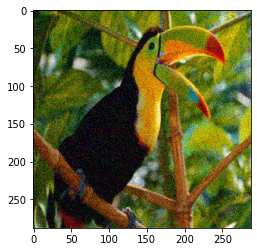

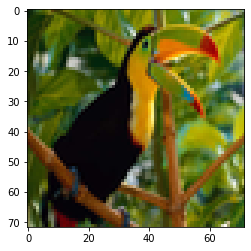

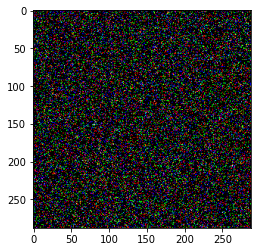

In [4]:
#gt image
img_pil, img_np = get_image(HR_image, imsize)    
#noise image
img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)
#LR image
imgs = load_LR_HR_imgs_sr(LR_image, HR_image , imsize, factor)
#inpainting mask
img_mask = get_bernoulli_mask(img_pil, zero_f)
img_mask_np = pil_to_np(img_mask)
img_mask_np[1] = img_mask_np[0]
img_mask_np[2] = img_mask_np[0]
#plot
plt.imshow(img_pil)
plt.pause(0.1) 
plt.imshow(img_noisy_pil) 
plt.pause(0.1) 
plt.imshow(imgs['LR_pil']) 
plt.pause(0.1) 
plt.imshow(img_mask)
plt.pause(0.1) 


SIREN model

In [5]:
#Input coordinate
def get_origin_mgrid(sidelen1,sidelen2, dim=2):
    '''Generates coordinates in a range of -1 to 1: if width is not equal to highth, the smaller one will be reduced in equal proportion '''
    if sidelen1 >=sidelen2:
      tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen1)])
      mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    
      minor=int((sidelen1-sidelen2)/2)
      mgrid=mgrid[:,minor:sidelen2+minor]
    if sidelen1 <sidelen2:
      tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen2)])
      mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
      
      minor=int((sidelen2-sidelen1)/2)
      mgrid=mgrid[minor:sidelen1+minor,:]
    mgrid = mgrid.reshape(-1, dim)
   
    return mgrid

#SIREN model  https://github.com/vsitzmann/siren
class SineLayer(nn.Module):
       
     
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        



Initialize

In [6]:
class ImageFitting(Dataset):
    def __init__(self,sidelength1,sidenlength2):
        super().__init__()
        
        
        self.coords = get_origin_mgrid(sidelength1,sidelength2,dim=2)
        
    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
          
        return self.coords

In [10]:
sidelength1=img_noisy_np.shape[1]
sidelength2=img_noisy_np.shape[2]
print(sidelength1,sidelength2)
image = ImageFitting(sidelength1,sidelength2)
dataloader = DataLoader(image, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=2, out_features=3, hidden_features=256, 
                  hidden_layers=6, outermost_linear=True)
img_siren.cuda()

288 288


Siren(
  (net): Sequential(
    (0): SineLayer(
      (linear): Linear(in_features=2, out_features=256, bias=True)
    )
    (1): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (2): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (3): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (4): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (5): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (6): SineLayer(
      (linear): Linear(in_features=256, out_features=256, bias=True)
    )
    (7): Linear(in_features=256, out_features=3, bias=True)
  )
)

Train

Step 0, Total loss 0.493977


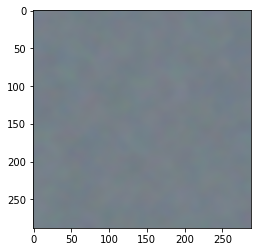

<ipython-input-11-4572ad83d5db>:77: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  SSIM = ssim(gt,output , multichannel=True)


ssim =  0.33156547
psnr =  9.439200301397985
time =  0.3154442310333252


Step 500, Total loss 0.003296


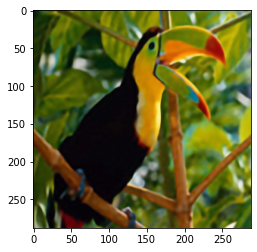

ssim =  0.961379
psnr =  33.24719337637394
time =  9.995179176330566


In [11]:
#total steps
total_steps = 500
#test steps
steps_til_summary = 500
start_time=time.time()
KERNEL_TYPE='lanczos2'
dtype = torch.cuda.FloatTensor
#initialize downsampler
downsampler = Downsampler(n_planes=3, factor=factor, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True).type(dtype)

#get all images
#noise
img_noisy_input=(img_noisy_np-0.5)*2
noisy_image = torch.tensor(img_noisy_input).permute(1,2,0).view(-1,3).cuda()  
#mask     
mask=torch.tensor(img_mask_np).permute(1,2,0).view(-1,3).cuda()
#gt
img_gt=torch.tensor(img_np).permute(1,2,0).view(-1,3).cuda()
img_gt=(img_gt-0.5)*2
#LR
img_LR_gt=torch.tensor(imgs['LR_np']).permute(1,2,0).view(-1,3).cuda()
img_LR_gt=(img_LR_gt-0.5)*2  

optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())
model_input= next(iter(dataloader))
model_input= model_input.cuda()
gt=img_np.transpose(1,2,0)
for step in range(total_steps+1):
    model_output, coords = img_siren(model_input)    
    #!!! choose different loss for different tasks

    # SR+denoise

    model_outputnew=(downsampler(model_output.view(sidelength1,sidelength2,3).permute(2,0,1))).permute(1,2,0).view(1,-1,3)
    loss1 = ((model_outputnew - img_LR_gt)**2).mean()
    loss2=((model_output - noisy_image)**2).mean()
    loss=loss1+0.1*loss2

    #mask+denoise

    # loss1 = (mask*(model_output - img_gt)**2).mean()
    # loss2=((model_output - noisy_image)**2).mean()
    # loss=loss1+0.1*loss2
    

    ##mask+SR
    # model_outputnew=(downsampler(model_output.view(sidelength1,sidelength2,3).permute(2,0,1))).permute(1,2,0).view(1,-1,3)
    # loss1 = (mask*(model_output - img_gt)**2).mean()
    # loss2 = ((model_outputnew - img_LR_gt)**2).mean()
    # loss=loss1+loss2

    #three
    # model_outputnew=(downsampler(model_output.view(sidelength1,sidelength2,3).permute(2,0,1))).permute(1,2,0).view(1,-1,3)
    # loss1 = (mask*(model_output - img_gt)**2).mean()
    # loss2 = ((model_outputnew - img_LR_gt)**2).mean()
    # loss3 =((model_output - noisy_image)**2).mean()
    # loss=loss1+loss2+0.1*loss3
    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
              
        output=model_output.cpu().view(sidelength1,sidelength2,3).detach().numpy()
        #outputforplot=model_output.cpu().view(1,sidelength1,sidelength2,3).detach().numpy()
        output=(output+1)/2
        #outputforplot=(outputforplot+1)/2
        

        plt.imshow(output)
        plt.pause(0.1)

        

        #save image
        # imgnewout=np_to_pil(outtt.transpose(2,0,1))
        # imgnewout.save('multi result/out1srmaskbiinr.png')

        #print metrics
        SSIM = ssim(gt,output , multichannel=True)
        print("ssim = ", SSIM)
        PSNR = psnr(gt,output )
        print("psnr = ", PSNR)
        end_time=time.time()
        print("time = ",end_time-start_time)
        
        
    
    optim.zero_grad()
    loss.backward()
    optim.step()

